# Modeling Stochastic Gradient Descent with SDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## (Q7) GD - SGD and SDE EM

In [2]:
n = 2; p = 2; x_0 = np.zeros(2)
np.random.seed(42)
M = np.random.normal(0,1,size=(2,2))
y = np.random.normal(0,1,size=n)
T = 50 ; h = 2.0**(-np.arange(1,5))
K = np.floor(T/h).astype(int)

### Gradient Descent
$x^{k+1} = x^k - h \nabla f(x^k)$ where $f(x) = \frac{1}{2n}\|Mx-y\|^2$, 

which lands $\nabla f(x) = \frac{1}{n}M^\top\|Mx-y\|$

In [8]:
f = lambda M,x,y : 0.5*np.linalg.norm(M@x-y)**2/len(y)
grad_f = lambda M,x,y : M.T@(M@x-y)/len(y)

def gd(grad_f,f,h,K,M,y,x_0):
    x_gd = np.zeros((K,2))
    x_gd[0] = x_0
    f_gd = np.zeros(K)
    f_gd[0] = f(M,x_0,y)
    for t in range(1,K):
        x_gd[t,:] = x_gd[t-1,:] - h*grad_f(M,x_gd[t-1,:],y)
        f_gd[t] = f(M,x_gd[t,:],y)
    return [x_gd,f_gd]

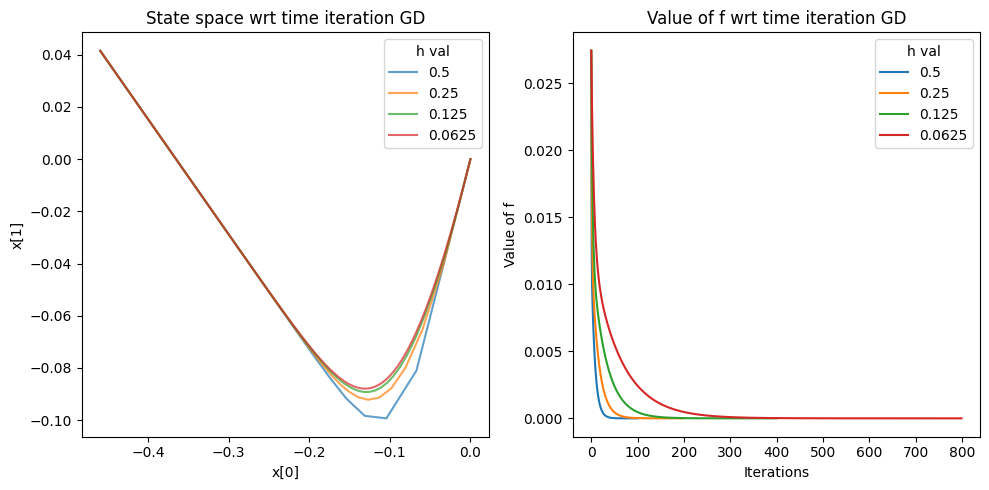

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i in range(len(h)):
    x_gd,f_gd = gd(grad_f,f,h[i],K[i],M,y,x_0)
    # x plots
    ax[0].plot(x_gd[:,0],x_gd[:,1],label=str(h[i]),alpha=0.7)
    ax[0].set_title("State space wrt time iteration GD")
    ax[0].set_xlabel("x[0]")
    ax[0].set_ylabel("x[1]")
    ax[0].legend(title="h val")
    # f plots
    ax[1].plot(f_gd,label=str(h[i]))
    ax[1].set_title("Value of f wrt time iteration GD")
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Value of f")
    ax[1].legend(title="h val")
plt.tight_layout()
plt.show()

### Stochastic Gradient Descent
If one supposes that $$f(x) = \frac{1}{n}\sum_{i=1}^nf_i(x),$$
the SGD gives us $x^{k+1} = x^k - h \nabla f_{i_k}(x^k)$ where $i_k \sim \operatorname{Uniform}(\{1,...,n\})$ and
$f_i(x) = \frac{1}{2n}|M_{i,\cdot}x-y_i|^2 \in \mathbb{R}$ 

which lands $\nabla f_i(x) = \frac{1}{n} M_{i,\cdot}^\top |M_{i,\cdot}x-y_i|$


$$\nabla \frac{1}{2} |\sum_{j=1}^p M_{i,j}x_j-y_i|^2 = |M_{i,\cdot}x-y_i| \nabla |\sum_{j=1}^p M_{i,j}x_j-y_i| = |M_{i,\cdot}x-y_i| \frac{\sum_{j=1}^p M_{i,j}x_j-y_i}{|M_{i,\cdot}x-y_i|}M_{i,\cdot}^\top = M_{i,\cdot}^\top(M_{i,\cdot}x-y_i) \in \mathbb{R}^p$$

In [27]:
L = 8

def sgd(f,h,K,M,y,x_0):
    x_sgd = np.zeros((K,2))
    x_sgd[0] = x_0
    f_sgd = np.zeros(K)
    f_sgd[0] = f(M,x_0,y)
    idx_grads = np.random.randint(low=0,high=n,size=K)
    for t in range(1,K):
        x_sgd[t,:] = x_sgd[t-1,:] - h*M[idx_grads[t],:]*(M[idx_grads[t],:]@x_sgd[t-1,:]-y[idx_grads[t]])
        f_sgd[t] = f(M,x_sgd[t,:],y)
    return [x_sgd,f_sgd]


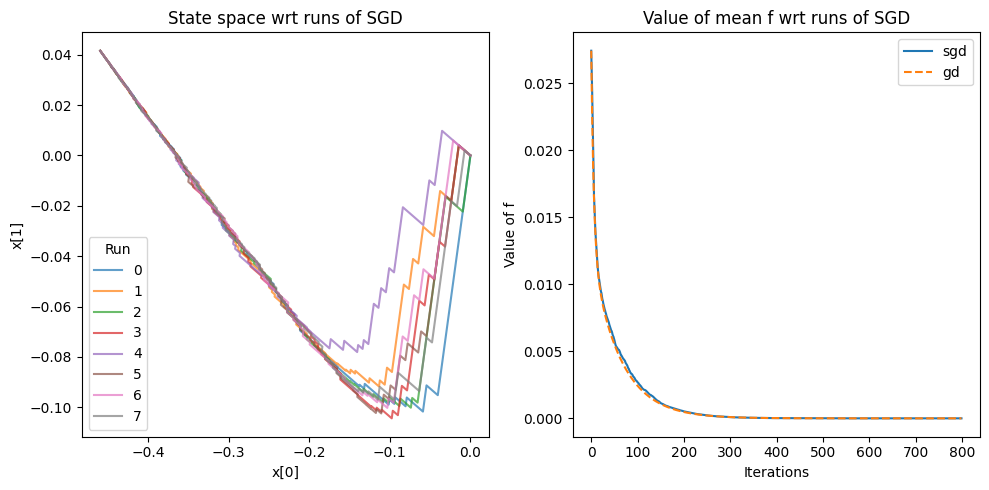

In [28]:
idx = 3
fig, ax = plt.subplots(1,2,figsize=(10,5))
f_tot = np.zeros(K[idx])
for l in range(L):
    x_sgd,f_sgd = sgd(f,h[idx],K[idx],M,y,x_0)
    f_tot += f_sgd
    # x plots
    ax[0].plot(x_sgd[:,0],x_sgd[:,1],label=str(l),alpha=0.7)
    ax[0].set_title("State space wrt runs of SGD")
    ax[0].set_xlabel("x[0]")
    ax[0].set_ylabel("x[1]")
    ax[0].legend(title="Run")
# f plots
f_tot /= L
ax[1].plot(f_tot,label="sgd")
ax[1].plot(f_gd,label="gd",ls="--")
ax[1].set_title("Value of mean f wrt runs of SGD")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Value of f")
ax[1].legend()
plt.tight_layout()
plt.show()

### Euler-Maruyama method for the SDE

$$d\widetilde{X}_t = - \nabla f(\widetilde{X}_t)dt + \sqrt{h} \tilde{\Sigma}(\widetilde{X}_t)^{\frac{1}{2}}dW_t \text{ where } \tilde{\Sigma}(x) = \frac{1}{n} M^\top \left[\frac{1}{n} \|Mx-y\|^2 I\right]M,$$ with $\widetilde{X}_0 = 0$.

By using the EM definition, we get:

$$\widetilde{X}_{n+1} = - \nabla f(\widetilde{X}_n) \Delta t + \sqrt{h} \tilde{\Sigma}(\widetilde{X}_n)^{\frac{1}{2}} \Delta W_n$$

In [55]:
g = lambda M,x,y : (1/len(y))*M.T@(2*f(M,x,y)*np.eye(len(y)))@M
def EM(grad_f,g,f,h,K,M,y,x_0):
    x_em = np.zeros((K,2))
    x_em[0] = x_0
    f_em = np.zeros(K)
    f_em[0] = f(M,x_0,y)
    for t in range(1,K):
        x_em[t,:] = x_em[t-1,:] - h*grad_f(M,x_em[t-1,:],y) \
                    + np.sqrt(h*g(M,x_em[t-1,:],y))@np.random.normal(loc=0, scale=np.sqrt(h),size=2)
        f_em[t] = f(M,x_em[t,:],y)
    return [x_em,f_em]
x_em,f_em = EM(grad_f,g,f,h[idx],K[idx],M,y,x_0)

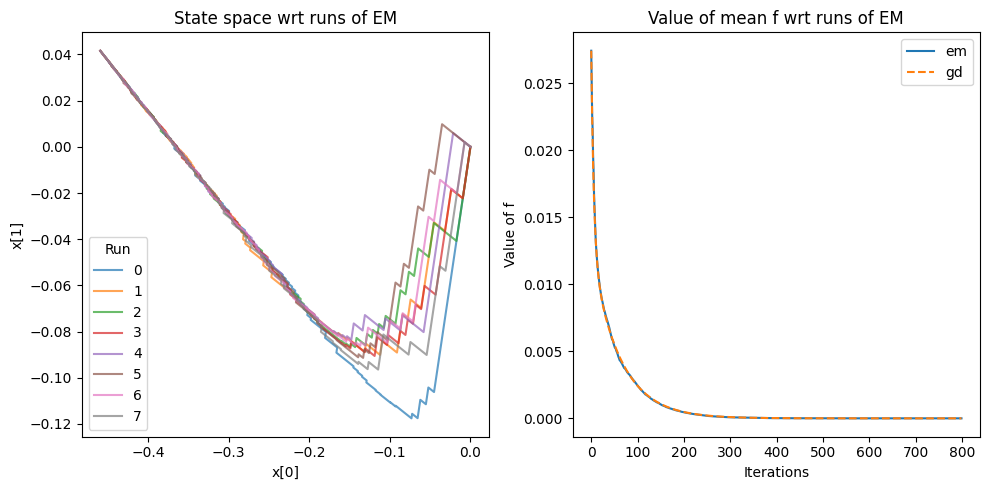

In [56]:
idx = 3
fig, ax = plt.subplots(1,2,figsize=(10,5))
f_tot = np.zeros(K[idx])
for l in range(L):
    x_em,f_em = sgd(f,h[idx],K[idx],M,y,x_0)
    f_tot += f_em
    # x plots
    ax[0].plot(x_em[:,0],x_em[:,1],label=str(l),alpha=0.7)
    ax[0].set_title("State space wrt runs of EM")
    ax[0].set_xlabel("x[0]")
    ax[0].set_ylabel("x[1]")
    ax[0].legend(title="Run")
# f plots
f_tot /= L
ax[1].plot(f_tot,label="em")
ax[1].plot(f_gd,label="gd",ls="--")
ax[1].set_title("Value of mean f wrt runs of EM")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Value of f")
ax[1].legend()
plt.tight_layout()
plt.show()